## Unit Root Detrend

#### Config

In [6]:
## load some packages
from pandas_datareader.fred import FredReader  # gets data without a bunch of csvs
import matplotlib.pyplot as plt  # make plots
import statsmodels.api as sm  # regressions
import numpy as np  # math things

# fonts look pretty
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })

#### Data

In [7]:
## data config
start = '1960-01'
end = '2007-12'
series = {
        'GDPDEF': 'gdpdef',  # gdp deflator
        'GDP': 'gdp',  # gdp
        'GCE': 'gov',  # govt spending
        'W006RC1Q027SBEA': 'tax',  # tax revenues
    }

## pull data
## pull the data
df = FredReader(series.keys(), start=start, end=end).read().rename(columns=series).dropna()

## adjust series
df = df[['gdp', 'gov', 'tax']].div(df['gdpdef'], axis=0)
# predetrend, want to know how much higher gdp is than gov
# so when we know 1% change in gov -> 1% change in gdp we can muliply it by that
mult = (df['gdp'] / df['gov']).mean()
df = np.log(df).diff().dropna()  # unit root detrend
df = df.sub(df.mean()) * 100

df

,gdp,gov,tax
DATE,,,
1960-04-01,-1.364103,0.192925,-2.723294
1960-07-01,-0.331713,2.243819,-1.787256
1960-10-01,-2.114171,0.483939,-2.667318
1961-01-01,-0.151956,0.519857,-1.117238
1961-04-01,0.860313,-0.182133,1.548946
...,...,...,...
2006-10-01,0.034570,0.539519,-0.259103
2007-01-01,-0.522131,-0.082227,0.674828
2007-04-01,-0.212221,0.413558,-0.595536


#### Data Plot

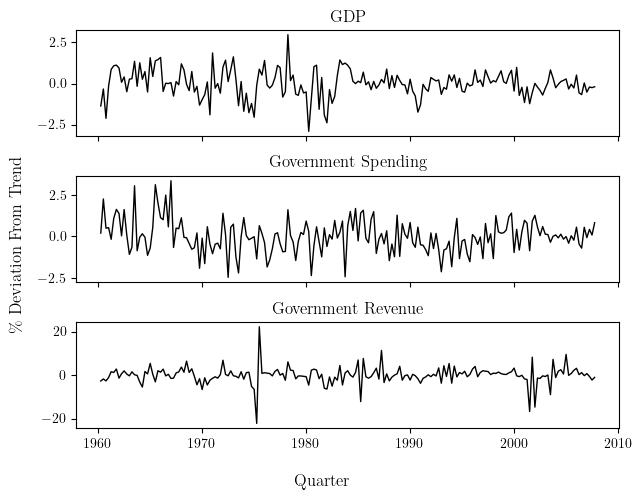

In [8]:
## plot setup
fig, axs = plt.subplots(3, sharex=True)
fig.set_figwidth(6.5)
fig.set_figheight(5)
fig.supxlabel('Quarter')
fig.supylabel(r'\% Deviation From Trend')

# gdp
axs[0].set_title('GDP')
axs[0].plot(df.index, df['gdp'], 'k-', linewidth=1)

# gov
axs[1].set_title('Government Spending')
axs[1].plot(df.index, df['gov'], 'k-', linewidth=1)

# tax
axs[2].set_title('Government Revenue')
axs[2].plot(df.index, df['tax'], 'k-', linewidth=1)

## final things
fig.tight_layout()

#### Results
$A = $ matrix multiplied by movements ($u$)

$B = $ matrix multiplied by error ($\varepsilon$)

#### Model 1
Set $b_2 = 0$

A: [[ 1.         -0.17970697 -0.14785807]
 [ 0.          1.          0.        ]
 [ 1.7         0.          1.        ]]
B: [[1.         0.         0.        ]
 [0.         1.         0.        ]
 [0.         0.74398102 1.        ]]


/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method ncg is: fhess_p, avextol, epsilon. The list of unsupported keyword arguments passed include: gtol. After release 0.14, this will raise.
  warnings.warn(


(0.7144433469505425, 0.0)

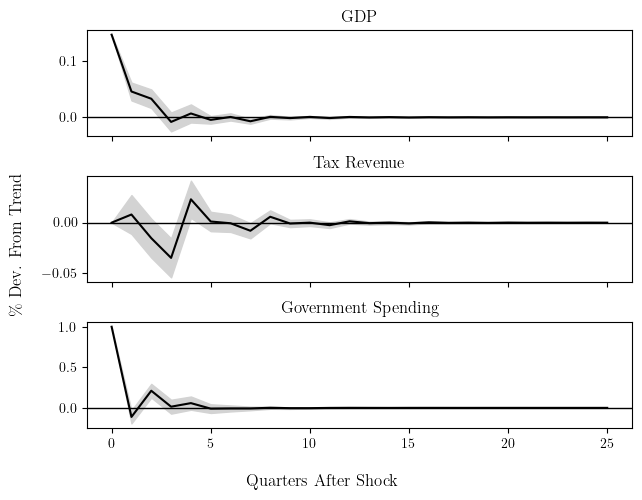

In [9]:
## svar
A = np.array([[1, 'E', 'E'], [0, 1, 0], [1.7, 0, 1]])
B = np.array([[1, 0, 0], [0, 1, 0], [0, 'E', 1]])
svar = sm.tsa.SVAR(df, svar_type='AB', A=A, B=B).fit(maxlags=4, solver='ncg')
# theres some frequency warning, I havent looked into how to stop that
print('A:', svar.A)
print('B:', svar.B)

## get the irf
T = 25
i = 2
irf = svar.irf(periods=T)
g_irf = irf.svar_irfs[:, :, i].T  # irf for a g shock
g_irf /= g_irf[2, 0]
g_irf_err = irf.stderr()[:, :, i].T / g_irf[2, 0]  # error band

## plot it (responce to g shock)
# plot setup
fig, axs = plt.subplots(3, sharex=True)
fig.set_figheight(5)
fig.set_figwidth(6.5)
fig.supylabel(r'\% Dev. From Trend')
fig.supxlabel('Quarters After Shock')
axs[0].set_title('GDP')
axs[1].set_title('Tax Revenue')
axs[2].set_title('Government Spending')

# plot the irfs
for i, ax in enumerate(axs):
    ax.axhline(0, c='k', linewidth=1)
    ax.fill_between(np.arange(T + 1), g_irf[i] - g_irf_err[i], g_irf[i] + g_irf_err[i], color='lightgray')
    ax.plot(g_irf[i], c='k')

# final things
fig.tight_layout()

## get the multiplier
idx = np.abs(g_irf[0]).argmax()
max_gdp_change = g_irf[0, idx]
max_gdp_err = g_irf_err[0, idx]
multiplier = max_gdp_change * mult  # make comprable units
multiplier_err = max_gdp_err * mult

multiplier, multiplier_err

#### Model 2
Set $c_2 = 0$

A: [[ 1.         -0.17970694 -0.14785805]
 [ 0.          1.          0.        ]
 [ 1.7         0.          1.        ]]
B: [[1.         0.         0.        ]
 [0.         1.         0.03289427]
 [0.         0.         1.        ]]


/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0.7505489914029462, 0.0)

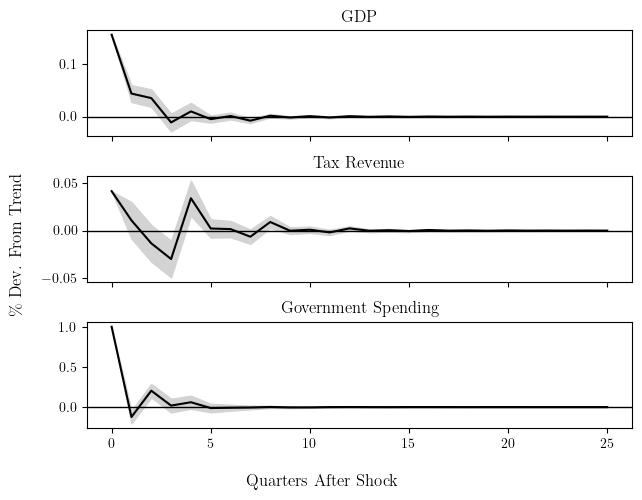

In [10]:
## svar
A = np.array([[1, 'E', 'E'], [0, 1, 0], [1.7, 0, 1]])
B = np.array([[1, 0, 0], [0, 1, 'E'], [0, 0, 1]])
svar = sm.tsa.SVAR(df, svar_type='AB', A=A, B=B).fit(maxlags=4, solver='ncg')
# theres some frequency warning, I havent looked into how to stop that
print('A:', svar.A)
print('B:', svar.B)

## get the irf
T = 25
i = 2
irf = svar.irf(periods=T)
g_irf = irf.svar_irfs[:, :, i].T  # irf for a g shock
g_irf /= g_irf[2, 0]
g_irf_err = irf.stderr()[:, :, i].T / g_irf[2, 0]  # error band

## plot it (responce to g shock)
# plot setup
fig, axs = plt.subplots(3, sharex=True)
fig.set_figheight(5)
fig.set_figwidth(6.5)
fig.supylabel(r'\% Dev. From Trend')
fig.supxlabel('Quarters After Shock')
axs[0].set_title('GDP')
axs[1].set_title('Tax Revenue')
axs[2].set_title('Government Spending')

# plot the irfs
for i, ax in enumerate(axs):
    ax.axhline(0, c='k', linewidth=1)
    ax.fill_between(np.arange(T + 1), g_irf[i] - g_irf_err[i], g_irf[i] + g_irf_err[i], color='lightgray')
    ax.plot(g_irf[i], c='k')

# final things
fig.tight_layout()

## get the multiplier
idx = np.abs(g_irf[0]).argmax()
max_gdp_change = g_irf[0, idx]
max_gdp_err = g_irf_err[0, idx]
multiplier = max_gdp_change * mult  # make comprable units
multiplier_err = max_gdp_err * mult

multiplier, multiplier_err